<h1 style="text-align:center"> Exploring and Predicting Characteristics of Japanese Newspaper Headlines </h1> 
 <h2 style="text-align:center"> <i>STA208 Final Project (Spring 2017)</i> </h2> 
 <h3 style="text-align:center"> <i>Tzu-ping Liu and Gento Kato</i> </h3> 


[<h5 style="text-align:center"> Back to Summary Notebook </h5>](STA208_Project_Summary.ipynb)

<h1 style="text-align:center"> Section IV </h1>
<h1 style="text-align:center"> <i>Exploring Categories of Newspaper Headlines</i> </h1>

In [22]:
# Computation Timer
from timeit import default_timer as trec

# Data Mining
import pandas as pd
import numpy as np
from sklearn import decomposition
from scipy.spatial.distance import cdist, pdist
from scipy import sparse as sp ## Sparse Matrix
from sklearn.cluster import KMeans, MiniBatchKMeans # Add MiniBatchKMeans

# Visualization
from IPython.display import display # Display HTML Table
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
start = trec() 

## Read data
alldata = pd.read_csv("../../data/alldata_traincode_170510.csv", encoding='CP932')
allWrdMat10 = pd.read_csv("../../data/allWrdMat10.csv.gz", encoding='CP932')

time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 307.608 seconds


In [3]:
start = trec() 

## Set X as CSR Sparse Matrix (Row Extraction is Faster) 
X = np.array(allWrdMat10)
X = sp.csr_matrix(X)

time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 42.177 seconds


**K-Means** 

Reduced <code>max_iter</code>, <code>n_init</code> to make classification a little faster. Also, <code>n_jobs = -1</code> to allow parallel computing.

In [4]:
start = trec() 

## K-Means
## Using the elbow nethod to determine the number of clusters
model_km = []; score_km = []
cluster = range(1, 16) ## 1- 15 clusters 
for a in cluster:
    kmeans = KMeans(n_clusters=a, random_state=0, n_init=1, max_iter=100, n_jobs = -1)
    km = kmeans.fit(X)
    ks = -(km.score(X))
    score_km.append(ks)
    model_km.append(km)
    
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 559.526 seconds


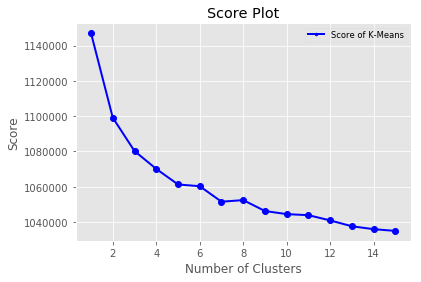

In [5]:
## Plotting the result
plt.plot(cluster, score_km, 'bo-', linewidth=2)
plt.title('Score Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
leg = plt.legend(['Score of K-Means'], loc='best', borderpad=0.3,
                 shadow=False, prop=mpl.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.draggable(state=True)
plt.show()

**MiniBatch K-Means** 

Randomly sample cases to conduct very efficient K-means. Here, random sample 1000 cases to execute each step.

In [6]:
start = trec() 

## MiniBatch K-Means
## Using the elbow nethod to determine the number of clusters
model_mkm = []; score_mkm = []
cluster = range(1, 16) ## 1- 15 clusters 
for a in cluster:
    kmeans = MiniBatchKMeans(n_clusters=a, random_state=0, n_init=1, init_size=1000, batch_size=1000)
    km = kmeans.fit(X)
    ks = -(km.score(X))
    score_mkm.append(ks)
    model_mkm.append(km)
    
time = trec() - start
print('Computation time is %0.3f seconds' % time)

Computation time is 6.189 seconds


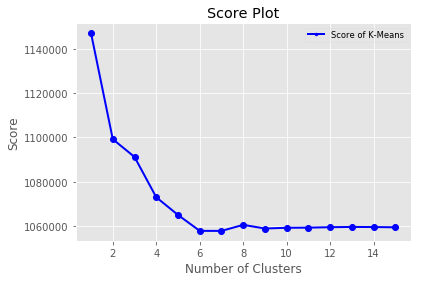

In [7]:
## Plotting the result
plt.plot(cluster, score_mkm, 'bo-', linewidth=2)
plt.title('Score Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
leg = plt.legend(['Score of K-Means'], loc='best', borderpad=0.3,
                 shadow=False, prop=mpl.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.draggable(state=True)
plt.show()

**Store Best Result and Compare Two Methods**

From the above, let's say there are 5 clusters.

In [27]:
## Choosing Nuber of cluster for Models
bestk = 5 ## Choose Cluster N
kmbest = model_km[bestk-1] # K-Means
mkmbest = model_mkm[bestk-1] # Mini-Batch K-Means

*Confusion Matrix of Two Methods*

In [28]:
## Make Prediction
pred_km = kmbest.predict(X) # K-Means
pred_mkm = mkmbest.predict(X) # Mini-Batch K-Means

## Confusion Matrix From Two Predictions
cm = pd.DataFrame({'K-Means': pred_km, 'Mini-Batch K-Means': pred_mkm}, 
                  columns = ['K-Means','Mini-Batch K-Means'])
pd.crosstab(cm['K-Means'], cm['Mini-Batch K-Means'], margins=True)

Mini-Batch K-Means,0,1,2,3,4,All
K-Means,,,,,,
0,19,6797,1,35,0,6852
1,435,2,211,251,6578,7477
2,2366,18,333,1315,5415,9447
3,1442,1,222,10156,761,12582
4,4208,0,4950,8,53627,62793
All,8470,6818,5717,11765,66381,99151


*Top 10 Words form each cluster of K-Means*

In [29]:
## Required Parameters
centroid_out = kmbest.cluster_centers_
order_centroids = centroid_out.argsort()[:, ::-1]
terms = allWrdMat10.columns

for i in range(bestk):
    print("Cluster %d:" % i)
    top10term = []
    top10cent = []
    for ind in order_centroids[i, :10]:
        top10term.append(terms[ind])
        top10cent.append(centroid_out[i,ind])
    table = pd.DataFrame(index = top10term, columns = ['cluster center component'], data = np.round(top10cent,3))
    table = table.transpose()
    display(table)

Cluster 0:


,０,１,２,円,５,３,人,万,億,４
cluster center component,2.55,0.641,0.538,0.436,0.3,0.291,0.278,0.273,0.247,0.218


Cluster 1:


,米,日,大統領,会談,軍,協議,首脳,イラク,首相,日本
cluster center component,1.106,0.285,0.154,0.134,0.113,0.1,0.092,0.084,0.067,0.067


Cluster 2:


,２,５,％,３,０,４,人,日,６,７
cluster center component,1.018,0.294,0.268,0.259,0.227,0.216,0.179,0.174,0.173,0.155


Cluster 3:


,１,０,２,円,３,５,人,日,４,年
cluster center component,1.26,0.254,0.243,0.234,0.232,0.219,0.199,0.198,0.188,0.159


Cluster 4:


,氏,首相,３,政府,４,５,自民,日,人,化
cluster center component,0.091,0.088,0.075,0.053,0.052,0.049,0.046,0.043,0.041,0.04


*Top 10 Words form each cluster of MIni-Batch K-Means*

In [23]:
## Required Parameters
centroid_out = mkmbest.cluster_centers_
order_centroids = centroid_out.argsort()[:, ::-1]
terms = allWrdMat10.columns

for i in range(bestk):
    print("Cluster %d:" % i)
    top10term = []
    top10cent = []
    for ind in order_centroids[i, :10]:
        top10term.append(terms[ind])
        top10cent.append(centroid_out[i,ind])
    table = pd.DataFrame(index = top10term, columns = ['cluster center component'], data = np.round(top10cent,3))
    table = table.transpose()
    display(table)

Cluster 0:


,３,％,２,０,５,１,年,人,４,６
cluster center component,1.034,0.235,0.21,0.203,0.2,0.197,0.166,0.165,0.163,0.142


Cluster 1:


,０,１,２,円,５,３,万,人,億,４
cluster center component,2.546,0.601,0.539,0.42,0.297,0.29,0.272,0.27,0.242,0.227


Cluster 2:


,氏,選,自民,党,首相,総裁,小沢,民主,２,知事
cluster center component,1.025,0.258,0.217,0.171,0.121,0.099,0.084,0.084,0.068,0.067


Cluster 3:


,１,２,０,円,５,日,４,人,６,９
cluster center component,1.241,0.505,0.315,0.312,0.292,0.242,0.238,0.235,0.192,0.19


Cluster 4:


,米,２,首相,日,５,４,政府,日本,人,６
cluster center component,0.111,0.083,0.08,0.075,0.059,0.056,0.054,0.045,0.045,0.042
